# Extracting Roll Returns through Future versus ETF Arbitrage

## Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [6]:
USOdf = pd.read_csv('data/USO_history.csv', skiprows=1)
USOdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
USOdf['Date'] = pd.to_datetime(USOdf['Date'], errors='coerce')
USOdf['Close'] = pd.to_numeric(USOdf['Close'], errors='coerce')

XLEdf = pd.read_csv('data/XLE_history.csv', skiprows=1)
XLEdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
XLEdf['Date'] = pd.to_datetime(XLEdf['Date'], errors='coerce')
XLEdf['Close'] = pd.to_numeric(XLEdf['Close'], errors='coerce')

F_CLdf = pd.read_csv('data/F_CL_history.csv', skiprows=1)
F_CLdf.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change %']
F_CLdf['Date'] = pd.to_datetime(F_CLdf['Date'], errors='coerce')
F_CLdf['Price'] = pd.to_numeric(F_CLdf['Price'], errors='coerce')

## Strategy

In [7]:
merged_df = pd.merge(pd.merge(USOdf[['Date', 'Close']], XLEdf[['Date', 'Close']], on='Date', suffixes=('_USO', '_XLE')), F_CLdf[['Date', 'Price']], on='Date')

merged_df['Futures_Daily_Change'] = merged_df['Price'].pct_change()

merged_df['Strategy_Return'] = 0.0

# Short USO and Long XLE whenever CL is in contango
merged_df.loc[merged_df['Futures_Daily_Change'] > 0, 'Strategy_Return'] = -merged_df['Close_USO'].pct_change() + merged_df['Close_XLE'].pct_change()

# Long USO and short XLE whenever CL is in backwardation
merged_df.loc[merged_df['Futures_Daily_Change'] <= 0, 'Strategy_Return'] = merged_df['Close_USO'].pct_change() - merged_df['Close_XLE'].pct_change()

## Cumulative Returns and Plotting

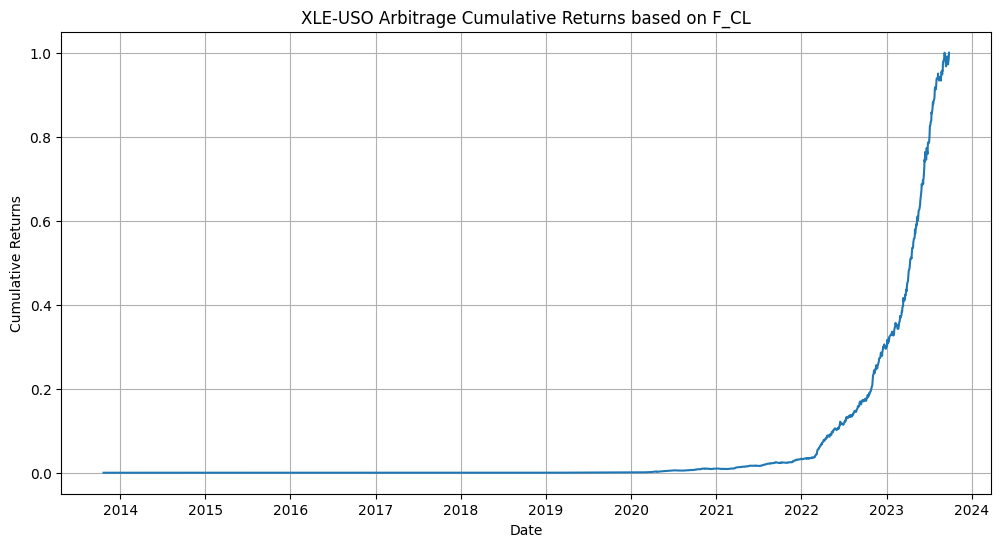

Sharpe Ratio: -6.80


In [8]:
merged_df['Cumulative_Returns'] = (1 + merged_df['Strategy_Return']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Cumulative_Returns'])
plt.title('XLE-USO Arbitrage Cumulative Returns based on F_CL')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Sharpe Ratio
risk_free_rate = 0.053
daily_returns = merged_df['Strategy_Return']
sharpe_ratio = (daily_returns.mean() - risk_free_rate/252) / daily_returns.std() * (252 ** 0.5)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")